In [ ]:
#!pip install git+https://github.com/amazon-science/chronos-forecasting.git

## Import libraries

In [1]:
import pandas as pd
from ta.volatility import BollingerBands
from ta.trend import CCIIndicator
from ta.momentum import RSIIndicator, PercentagePriceOscillator
import os

import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="mps",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

## Splitting data. Training till 2016 and testing from 2016-19

In [16]:
df_old = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")
df=pd.read_csv('../data/AAPL_processed.csv')
df=df.dropna().reset_index(drop=True)
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')

df_train=df[df['date']<='2016-12-31']
df_test=df[df['date']>'2016-12-31']

In [17]:
prediction_length = 60

forecast_values=df_train["adj close"].values

low_list=[]
high_list=[]

while len(forecast_values)<df.shape[0]:
  context = torch.tensor(forecast_values)
  forecast = pipeline.predict(
      context,
      prediction_length,
      num_samples=20,
      temperature=1.0,
      top_k=50,
      top_p=1.0,
  )

  low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
  forecast_values=np.append(forecast_values,median)
  low_list.append(low)
  high_list.append(high)


forecast_values=forecast_values[df_train.shape[0]:df.shape[0]]
low=np.array(low_list).reshape(-1,)
high=np.array(high_list).reshape(-1,)

low=low[:df_test.shape[0]]
high=high[:df_test.shape[0]]

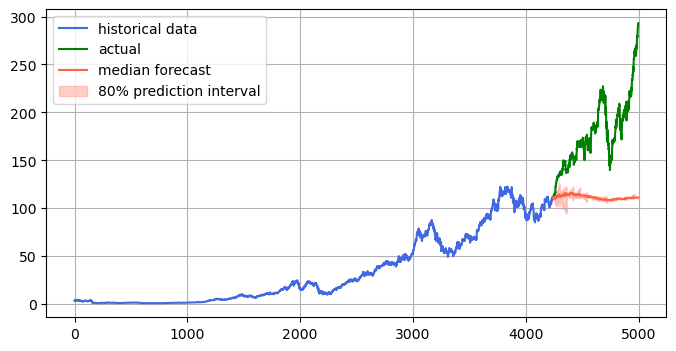

In [18]:
forecast_index = range(len(df_train), len(df_train) + len(forecast_values))
plt.figure(figsize=(8, 4))
plt.plot(df_train["adj close"], color="royalblue", label="historical data")
plt.plot(df_test["adj close"], color="green", label="actual")
plt.plot(forecast_index, forecast_values, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

In [20]:
df_test['prediction']=forecast_values

/var/folders/_p/cpzbk4z16cj_v913_1nkmx200000gn/T/ipykernel_54536/3548069806.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['prediction']=forecast_values


In [21]:
df_test.head()

,date,open,high,low,close,adj close,volume,SMA,BB%,RSI,CCI,PPO,PPO_signal,Signal,prediction
4244,2017-01-03,115.800003,116.330002,114.760002,116.150002,110.691154,28781900,111.137177,0.629855,59.416557,29.369280,1.136741,1.165698,1,110.676697
4245,2017-01-04,115.849998,116.510002,115.750000,116.019997,110.567276,21118100,111.078089,0.596174,58.512421,36.094495,1.057157,1.143990,0,110.676697
4246,2017-01-05,115.919998,116.860001,115.809998,116.610001,111.129562,22193600,111.045688,0.657233,61.384735,46.034032,1.023338,1.119859,2,110.676697
4247,2017-01-06,116.779999,118.160004,116.470001,117.910004,112.368469,31751900,111.126694,0.865555,66.833296,108.931942,1.074351,1.110758,2,111.445282
4248,2017-01-09,117.949997,119.430000,117.940002,118.989998,113.397697,33561900,111.384004,1.057731,70.550820,203.534513,1.175548,1.123716,2,111.060989


In [22]:
sma_window = 10
ppo_slow_ema = 26
ppo_fast_ema = 12
ppo_signal = 9

sma = df_test["prediction"].rolling(window=sma_window).mean()
df_test["SMA_pred"] = sma

# Bollinger Bands
indicator_bb = BollingerBands(close=df_test["prediction"])
df_test['BB%_pred'] = (df_test['prediction'] - indicator_bb.bollinger_lband()) / (indicator_bb.bollinger_hband() - indicator_bb.bollinger_lband())

# RSI
rsi_indicator = RSIIndicator(close=df_test['prediction'])
df_test['RSI_pred'] = rsi_indicator.rsi()

# CCI
cci_indicator = CCIIndicator(high=df_test['high'], low=df_test['low'], close=df_test['prediction'])
df_test['CCI_pred'] = cci_indicator.cci()

# PPO and PPO Signal
indicator_ppo = PercentagePriceOscillator(df_test['prediction'], window_slow=ppo_slow_ema, window_fast=ppo_fast_ema, window_sign=ppo_signal)

# Create a DataFrame to store PPO and its signal line
df_test['PPO_pred'] = indicator_ppo.ppo()
df_test['PPO_signal_pred'] = indicator_ppo.ppo_signal()


/var/folders/_p/cpzbk4z16cj_v913_1nkmx200000gn/T/ipykernel_54536/2051267258.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["SMA_pred"] = sma
/var/folders/_p/cpzbk4z16cj_v913_1nkmx200000gn/T/ipykernel_54536/2051267258.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['BB%_pred'] = (df_test['prediction'] - indicator_bb.bollinger_lband()) / (indicator_bb.bollinger_hband() - indicator_bb.bollinger_lband())
/var/folders/_p/cpzbk4z16cj_v913_1nkmx200000gn/T/ipykernel_54536/2051267258.py:15:

## Derive signal from the predicted closing value

In [23]:
def assign_trading_signals(df):
    """
    Function to assign signal considering volatility
    """

    volatility_threshold = 0.02  # Example threshold, adjust as needed
    df['New_Signal']=2

    for i in range(1, len(df)):
        # ... (Your existing logic for buy_signals, sell_signals) ...
        buy_signals = 0
        sell_signals = 0

        # PPO rule
        if df['PPO_pred'].iloc[i] > df['PPO_signal_pred'].iloc[i] and df['PPO_pred'].iloc[i-1] <= df['PPO_signal_pred'].iloc[i-1]:
            buy_signals += 1
        elif df['PPO_pred'].iloc[i] < df['PPO_signal_pred'].iloc[i] and df['PPO_pred'].iloc[i-1] >= df['PPO_signal_pred'].iloc[i-1]:
            sell_signals += 1

        # CCI rule
        if df['CCI_pred'].iloc[i] > -100 and df['CCI_pred'].iloc[i-1] <= -100:
            buy_signals += 1
        elif df['CCI_pred'].iloc[i] < 100 and df['CCI_pred'].iloc[i-1] >= 100:
            sell_signals += 1

        # Bollinger Bands % rule
        if df['BB%_pred'].iloc[i] > 0.2 and df['BB%_pred'].iloc[i-1] <= 0.2:
            buy_signals += 1
        elif df['BB%_pred'].iloc[i] < 0.8 and df['BB%_pred'].iloc[i-1] >= 0.8:
            sell_signals += 1

        # RSI rule
        if df['RSI_pred'].iloc[i] > 30 and df['RSI_pred'].iloc[i-1] <= 30:
            buy_signals += 1
        elif df['RSI_pred'].iloc[i] < 70 and df['RSI_pred'].iloc[i-1] >= 70:
            sell_signals += 1

        # Incorporate volatility
        if buy_signals > sell_signals:
            df.loc[i, 'New_Signal'] = 0
        elif sell_signals > buy_signals:  # Keep sell logic as-is
            df.loc[i, 'New_Signal'] = 1
    return df

In [24]:
finaldf=assign_trading_signals(df_test)

/var/folders/_p/cpzbk4z16cj_v913_1nkmx200000gn/T/ipykernel_54536/3969365541.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['New_Signal']=2
/var/folders/_p/cpzbk4z16cj_v913_1nkmx200000gn/T/ipykernel_54536/3969365541.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[i, 'New_Signal'] = 0


In [27]:
finaldf.tail()

,date,open,high,low,close,adj close,volume,SMA,BB%,RSI,...,PPO_signal,Signal,prediction,SMA_pred,BB%_pred,RSI_pred,CCI_pred,PPO_pred,PPO_signal_pred,New_Signal
722,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
726,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
732,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
733,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
735,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

y_true=finaldf['Signal'].tolist()
y_pred=finaldf['New_Signal'].tolist()

cm = confusion_matrix(y_true, y_pred)
print(cm)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Precision
precision_macro = precision_score(y_true, y_pred, average='macro')
precision_per_class = precision_score(y_true, y_pred, average=None)
print("Precision (macro):", precision_macro)
print("Precision (per class):", precision_per_class)

# Recall
recall_macro = recall_score(y_true, y_pred, average='macro')
recall_per_class = recall_score(y_true, y_pred, average=None)
print("Recall (macro):", recall_macro)
print("Recall (per class):", recall_per_class)

ValueError: Input y_true contains NaN.

In [ ]:
finaldf.drop(columns=['open', 'high', 'low', 'close','volume', 'SMA','BB%', 'RSI', 'CCI', 'PPO', 'PPO_signal','SMA_pred', 'BB%_pred', 'RSI_pred', 'CCI_pred', 'PPO_pred','PPO_signal_pred'],inplace=True)
finaldf.rename(columns={'Signal':'Signal_actual','New_Signal':'Signal'},inplace=True)


In [ ]:
finaldf.to_csv('Chronos_output.csv',index=False)

## Evaluation using metrics and simulation strategy

In [ ]:
import os
os.listdir('../utils')

In [ ]:
from utils.evaluation import *

In [30]:
chronosdf=pd.read_csv('../Chronos_output.csv')
chronosdf['date']=pd.to_datetime(chronosdf['date'],format='%Y-%m-%d')
chronosdf=chronosdf[(chronosdf['date'] >= "2017-01-01") & (chronosdf['date'] <= "2019-12-31")]
chronosdf.set_index('date',inplace=True)

In [63]:
def evaluate_strategy(stock, output):
    """
    Simulates a trading strategy based on predefined buy and sell signals over a specified period. 
    The function calculates and returns the detailed trade transactions and the overall portfolio value over time.

    Parameters:
    - stock (str): The ticker symbol of the stock for which the trading strategy is to be evaluated.
    - output (pd.DataFrame): A DataFrame with signals for trading; '0' indicates a buy signal, 
        and '1' indicates a sell signal. The DataFrame must be indexed by the date.

    Returns:
    - trades_df (pd.DataFrame): A DataFrame that records the trading actions taken (shares bought or sold) 
        and the cash balance after each trade.
    - values_df (pd.DataFrame): A DataFrame that tracks the total portfolio value over time, calculated as the 
        sum of the cash balance and the market value of the stock holdings.

    Details:
    - The strategy uses historical price data from a CSV file, filtering data from January 1, 2017, to December 31, 2019.
    - The strategy simulates trades by executing buy and sell orders based on the signals in the 'output' DataFrame. 
        The trades are constrained by a maximum limit of 1000 shares that can be bought or sold at any given signal.
    - The cash balance is adjusted according to the trades executed, and the stock positions are updated accordingly.
    - The function assumes that the initial cash balance is $1,000,000, starting with no stock holdings.
    - Cumulative holdings are calculated by accumulating trades over time to reflect the ongoing position in the stock 
        and the cash balance.
    - The portfolio value is computed by multiplying the number of shares held at each date by the stock's closing 
        price on that date, adding it to the cash balance.

    Example Usage:
    >>> output = pd.DataFrame({'Signal': [0, 1, 0, 1]}, index=pd.date_range(start='2017-01-01', periods=4))
    >>> trades_df, values_df = evaluate_strategy('AAPL', output)
    >>> print(trades_df.head())
    >>> print(values_df.head())

    Note:
    - The function assumes that the 'output' DataFrame dates align with the trading days in the stock's price data.
        Ensure that non-trading days (weekends, holidays) are handled or excluded from the 'output' DataFrame prior to use.
    """

    # Get stock prices for AAPL
   
    prices = pd.read_csv(f'{stock}.csv')[['date', 'adj close']]
    prices['date']=pd.to_datetime(prices['date'],format='%Y-%m-%d')
    prices = prices[(prices['date'] >= "2017-01-01") & (prices['date'] <= "2019-12-31")] # Testing split 
    prices= prices[prices['date'].isin(output.index)]
    prices = prices.iloc[::-1]
    prices['date'] = pd.to_datetime(prices['date'])
    prices.set_index('date', inplace=True)
    
    output.index = prices.index

    # Simulation 
    start_val = 1000000
    trades_df = pd.DataFrame(index=prices.index, columns=[stock, 'Cash'])
    trades_df.fillna(0, inplace=True)
    trades_df['Cash'] = 0  # Set initial cash

    # Simulate trades based on signals
    current_pos = 0 # Intial Position 
    max_shares = 1000  # Maximum shares to buy or sell
    for date, signal in output['Signal'].items():
        if date in trades_df.index:
            price = prices.loc[date, 'adj close']  # Use .loc for label-based indexing
            if signal == 0 and current_pos < max_shares:  # Buy signal
                shares_to_buy = min(max_shares - current_pos, 1000)
                trades_df.loc[date, stock] += shares_to_buy
                trades_df.loc[date, "Cash"] -= price * shares_to_buy
                current_pos += shares_to_buy
            elif signal == 1 and current_pos > -max_shares:  # Sell signal
                shares_to_sell = min(max_shares + current_pos, 1000)
                trades_df.loc[date, stock] -= shares_to_sell
                trades_df.loc[date, "Cash"] += price * shares_to_sell
                current_pos -= shares_to_sell 
    
    # Calculate cumulative holdings
    holdings_df = pd.DataFrame(0, index=trades_df.index, columns=trades_df.columns)
    holdings_df.iloc[0, :-1] = trades_df.iloc[0, :-1]
    holdings_df.iloc[0,-1] = start_val + trades_df.iloc[0, -1]
    for i in range(1, len(holdings_df)):
        holdings_df.iloc[i] = holdings_df.iloc[i - 1] + trades_df.iloc[i]        

    # Calculate portfolio value
    values_df = pd.DataFrame(index=prices.index, columns=["Portfolio Value"])
    values_df['Portfolio Value'] = holdings_df[stock] * prices['adj close'] + holdings_df['Cash']
    return trades_df, values_df

def get_benchmark(stock, sv=100000):
    """
    Retrieves the benchmark performance of a given stock using historical price data.
    This function simulates a basic investment strategy where a fixed number of shares are 
    bought at the beginning of the period and held until the end. It provides a simple 
    benchmark for evaluating the performance of more complex trading strategies.

    Parameters:
    - stock (str): The ticker symbol for the stock to be analyzed.
    - sv (int, optional): The starting value of the portfolio in dollars. Defaults to 100,000.

    Returns:
    - pd.DataFrame: A DataFrame indexed by date, with a single column 'Portfolio Value' that
      shows the value of the portfolio over time based on the performance of the stock.

    The function calculates the cumulative return, the standard deviation, and the average of 
    daily returns of the portfolio. It also prints these statistics for quick reference.

    Usage:
    >>> values_df = get_benchmark('AAPL')
    >>> print(values_df)

    Details:
    - The function buys 1000 shares of the stock at the start of the period and calculates the 
      portfolio value across the selected date range from "2017-01-01" to "2019-12-31".
    - The portfolio's daily values are calculated based on the closing prices of the stock, 
      and the remaining cash (if any) after the initial stock purchase is added to the 
      portfolio value.
    - Cumulative return, standard deviation of daily returns, and average daily returns are 
      calculated to provide a statistical summary of the stock's performance over the period.
    """
    
    prices = pd.read_csv(f'{stock}.csv')[['date', 'adj close']]
    prices = prices[(prices['date'] >= "2017-01-01") & (prices['date'] <= "2019-12-31")] # Testing split 

    prices = prices.iloc[::-1]
    prices['date'] = pd.to_datetime(prices['date'])
    prices.set_index('date', inplace=True)
    
    values_df = pd.DataFrame(0, index=prices.index, columns=["Portfolio Value"])
    
    leftover = sv - 1000 * prices['adj close'].iloc[0]    
    values_df["Portfolio Value"] = 1000 * prices["adj close"] + leftover

    # Portfolio value stats  
    cum_ret = values_df['Portfolio Value'].iloc[-1] / values_df['Portfolio Value'].iloc[0] - 1
    daily_rets = values_df['Portfolio Value']/ values_df['Portfolio Value'].shift(1) - 1
    std_daily_rets = daily_rets.std()
    avg_daily_rets = daily_rets.mean()
    print(f"Benchmark cumulative return: {cum_ret}, std: {std_daily_rets}, avg: {avg_daily_rets}")
    return values_df

def calculate_stats(values_df):
    """
    Calculate key statistics from a DataFrame of portfolio values. This function computes the 
    cumulative return, the standard deviation of daily returns, and the average daily returns
    of the portfolio. It is intended to be run with the output DataFrame from the 
    `evaluate_strategy()` function, which provides daily portfolio values.

    Parameters:
    - values_df (pd.DataFrame): DataFrame with a single column containing the daily portfolio 
      values indexed by date.

    Returns:
    - cum_ret (float): The cumulative return of the portfolio over the period. Calculated as 
      the percentage change from the first to the last value of the portfolio.
    - std_daily_rets (float): The standard deviation of the daily returns, which measures the 
      volatility of the daily portfolio returns.
    - avg_daily_rets (float): The average of the daily returns, indicating the typical daily 
      return of the portfolio.

    Usage Example:
    >>> trade_values,portfolio_values = evaluate_strategy('AAPL', output)
    >>> cumulative_return, daily_return_std, daily_return_avg = calculate_stats(portfolio_values)
    """
    cum_ret = values_df.iloc[-1] / values_df.iloc[0] - 1
    daily_rets = values_df/ values_df.shift(1) - 1
    std_daily_rets = daily_rets.std()
    avg_daily_rets = daily_rets.mean()
    return cum_ret, std_daily_rets, avg_daily_rets

def plot_fn(trades_df, values_df, stock):
    """
    Generates a plot comparing the performance of a trading strategy against a benchmark, 
    along with visual indicators for trading actions. The plot shows the normalized value 
    of the trading strategy and the benchmark, which allows for an easy comparison of 
    performance over time. Trade entries for long and short positions are marked with 
    vertical lines.

    Parameters:
    - trades_df (pd.DataFrame): A DataFrame indexed by date, containing trade quantities
      for the specified stock. Positive values indicate buys (LONG entries) and negative 
      values indicate sells (SHORT entries).
    - values_df (pd.DataFrame): A DataFrame indexed by date containing the daily portfolio
      value of the trading strategy.
    - stock (str): The ticker symbol of the stock being traded and plotted.

    Returns:
    - None: This function does not return any value. Instead, it displays a plot and saves 
      it to a file.

    Details:
    - The function first retrieves the benchmark performance using the `get_benchmark` function.
    - Both the portfolio and benchmark values are normalized to 1 at the start of the period 
      for comparability.
    - It plots these normalized values, with the trading strategy in red and the benchmark in 
      purple.
    - Entry points for trades are marked: blue vertical lines for LONG entries and black for 
      SHORT.
    - The plot includes labels for the axes, a title, and a custom legend explaining all 
      elements in the plot.
    - The resulting plot is saved to a file named after the stock in a 'results' directory.

    Usage Example:
    >>> trades_df = pd.DataFrame({ 'AAPL': [100, -100, 0, 100]}, index=pd.date_range(start='2020-01-01', periods=4))
    >>> values_df = pd.DataFrame({'Portfolio Value': [100000, 105000, 103000, 107000]}, index=pd.date_range(start='2020-01-01', periods=4))
    >>> plot(trades_df, values_df, 'AAPL')

    Note:
    - This function relies on matplotlib for plotting, ensure this library is installed and 
      imported as plt. It also uses Line2D from matplotlib.lines for custom legend entries.
    """

    benchmark = get_benchmark(stock)

    # Normalize port_val and benchmark to 1.0 at the start
    port_val_normalized = values_df / values_df.iloc[0]
    benchmark_normalized = benchmark['Portfolio Value'] / benchmark['Portfolio Value'].iloc[0]

    # Create a plot
    plt.figure(figsize=(12, 6))

    # Plotting the normalized port_val and benchmark
    plt.plot(port_val_normalized.index, port_val_normalized, color='red', label='DQN')
    plt.plot(benchmark_normalized.index, benchmark_normalized, color='purple', label='Benchmark')

    # Adding vertical lines for LONG and SHORT entry points
    for date, row in trades_df.iterrows():
        if row[stock] > 0:  # LONG entry
            plt.axvline(x=date, color='blue', linestyle='--', alpha=0.7)
        elif row[stock] < 0:  # SHORT entry
            plt.axvline(x=date, color='black', linestyle='--', alpha=0.7)

    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('Normalized Value')
    plt.title(f'Trading Strategy vs. Benchmark Performance with Trade Entry Points')

    # Create custom lines for the legend
    custom_lines = [Line2D([0], [0], color='red', lw=2),
                    Line2D([0], [0], color='purple', lw=2),
                    Line2D([0], [0], color='blue', lw=2, linestyle='--'),
                    Line2D([0], [0], color='black', lw=2, linestyle='--')]

    # Create the legend with all elements
    plt.legend(custom_lines, ['Trading Strategy', 'Benchmark', 'LONG Entry Points', 'SHORT Entry Points'])

    # plt.legend()
    # Show the plot
    plt.tight_layout()
    plt.savefig(f'{stock}.png')
    plt.show()



In [72]:
trades_df, values_df = evaluate_strategy('AAPL', chronosdf)
# values_df = get_benchmark('AAPL')
cumulative_return, daily_return_std, daily_return_avg = calculate_stats(values_df)

Benchmark cumulative return: 1.8226355743408202, std: 0.016568218787796758, avg: 0.001516499434650555


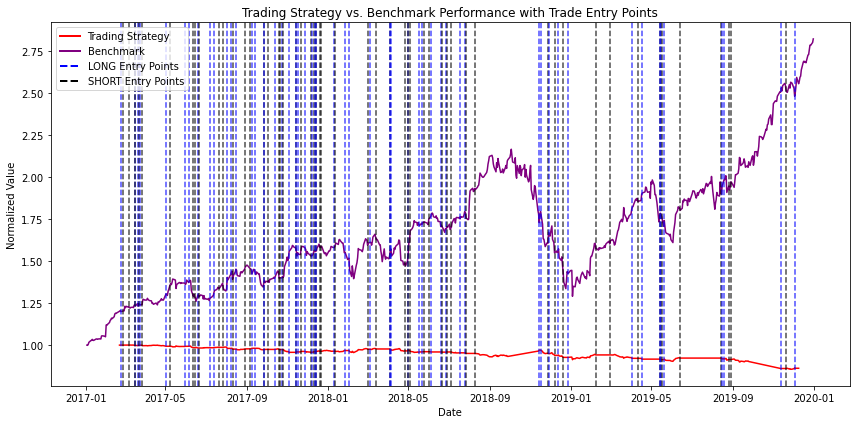

In [73]:
plot_fn(trades_df, values_df, 'AAPL')